## Costs



In [1]:
import warnings
warnings.filterwarnings('ignore',category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install CFEDemands --upgrade --ignore-installed
!pip install xarray --ignore-installed
!pip install dvc[gdrive] --ignore-installed
!pip install h5netcdf --ignore-installed

  Using cached CFEDemands-0.2.9-py2.py3-none-any.whl (36 kB)
  Using cached xarray-0.17.0-py3-none-any.whl (759 kB)
  Using cached pandas-1.2.4-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Using cached setuptools-56.0.0-py3-none-any.whl (784 kB)
  Using cached numpy-1.20.2-cp38-cp38-manylinux2010_x86_64.whl (15.4 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.4.0 requires h5py~=2.10.0, but you'll have h5py 3.2.1 which is incompatible.
tensorflow 2.4.0 requires numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
tensorflow 2.4.0 requires 

In [3]:
COUNTRY = 'Uganda'
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/'}
DAYS_PER_PERIOD = {'Uganda':7} # Number of days of expenditure recall

In [4]:
from eep153_tools import read_sheets

my_creds = '../students.json'

### Loading in Estimation

In [5]:
import cfe
r = cfe.from_dataset("my Uganda griffith.ds")

In [6]:
r

<xarray.Result>
Dimensions:           (i: 51, j: 10159, k: 15, kp: 15, m: 1, t: 6)
Coordinates:
  * i                 (i) object 'Beans' 'Beef' ... 'Water' 'Wheat (flour)'
  * k                 (k) object 'F 00-03' 'M 00-03' ... 'M 51+' 'log HSize'
  * t                 (t) object '2005-06' '2009-10' ... '2013-14' '2015-16'
  * m                 (m) object 'Uganda'
  * j                 (j) object '1013000201' '1013000202' ... 'H4301001'
  * kp                (kp) object 'F 00-03' 'F 04-08' ... 'M 51+' 'log HSize'
Data variables: (12/20)
    alpha             (i) float64 6.538 7.501 8.361 6.426 ... 5.816 nan nan
    beta              (i) float64 0.2344 0.3721 0.5759 0.6146 ... 0.462 nan nan
    delta             (k, i) float64 -0.018 -0.02526 -0.01543 ... nan nan
    prices            (i, t, m) float64 600.0 1.25e+03 ... 2.5e+03 2.7e+03
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946
    loglambdas        (j, t, m) float64 -1.233 0.01116 -0.6326 ... nan -0.4518
    ...                ...
    se_beta           float64 nan
    se_alpha          (i) float64 0.01585 0.01851 0.07667 ... 0.01593 0.0 0.0
    se_a              (i, t, m) float64 0.01585 0.01713 0.0173 ... nan nan nan
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 6.397 7.131 7.313 ... nan 7.824 7.901
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946
Attributes:
    firstround:            2005-06
    min_proportion_items:  0.125
    min_xproducts:         30
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

### Nutrient Demands



The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product, and establishing the ceritus paribus first for salt:



In [7]:
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[40] # salt

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

In [8]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='./students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [9]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,,,,,,,,,,,,,,,
Beans,1060,65,50,1040,270,191,16.0,2.86,0.49,0.87,0,0.0,0.73,14,7.0
Beef,2910,264,0,50,90,0,27.0,33.50,2.20,0.50,0,18.5,1.70,0,60.0
Beer,430,5,0,60,40,35,0.0,5.10,0.30,0.10,0,0.2,0.50,0,0.0
Bread,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Bun,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Cabbages,250,13,30,430,400,58,5.0,2.34,0.40,0.61,50,0.0,1.24,366,2.0
Cassava,1600,14,20,270,160,381,3.0,8.54,0.48,0.87,10,0.0,0.88,206,3.0
Cassava (flour),3140,26,40,360,310,766,19.0,14.00,0.50,3.10,70,0.0,7.00,720,7.0
Chapati,2750,91,20,240,860,557,14.0,21.42,0.97,2.67,0,0.0,0.34,0,8.0


### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [10]:
rdi = read_sheets(URL[COUNTRY],
                  json_creds='./students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

k,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


We will subsidize the following items, bread, salt, maize, and beans. We chose these items because they are the most common items to fortify with iron, vitamin A, Zinc, vitamin B12 and are fairly cheap to produce. Let's look at their original nutritional contents:

#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [11]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()

Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [12]:
UseNutrients = ['Iron','Vitamin A', 'Vitamin B-12', 'Zinc']

In [13]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi.loc[UseNutrients] # Only looking at our nutrients of interest

,z
n,
Iron,379.840807
Vitamin A,22817.040359
Vitamin B-12,68.698655
Zinc,278.130045


#### Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [14]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

In the above graph we see that households with a log budget between 0-25000 have inadequate levels of our selected nutrients, except for Vitamin A which extends farther to log budget households up to 150,000.

### Simple Policy Experiments



Consider two policies:  First, changing income so that some proportion
 of the population achieves nutritional adequacy.  Here choose quantile
 we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
 of 0.25 is the household at the 25th percentage point of the distribution).



In [15]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Compensated Policy Experiments



In [16]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

#### Compensated nutrient adequacy for salt

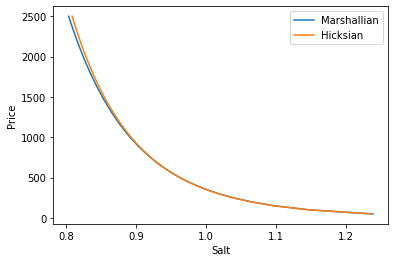

In [17]:
my_i = 'Salt'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"));

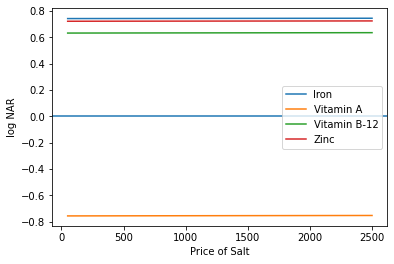

In [18]:
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i);

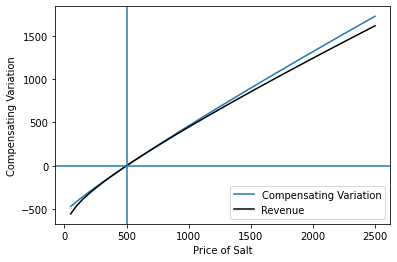

In [19]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i]);

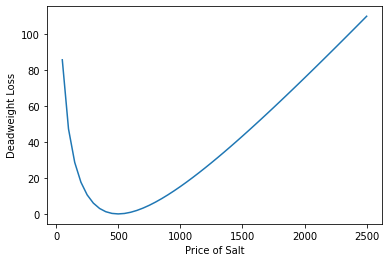

In [20]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss");

#### Compensated nutrient adequacy for bread buns

In [21]:
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[3] # buns

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

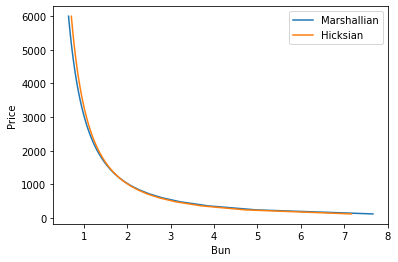

In [22]:
my_i = 'Bun'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"));

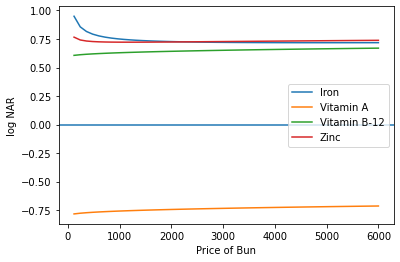

In [23]:
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i);

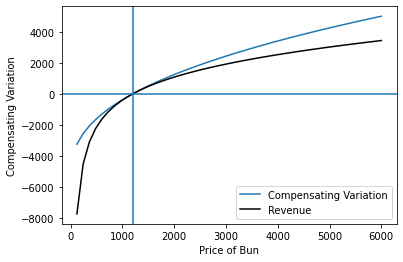

In [24]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i]);

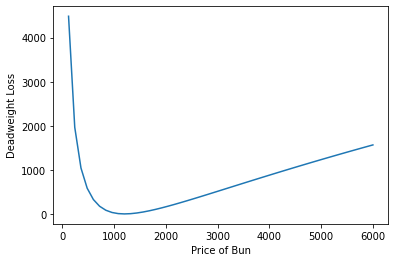

In [25]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss");

#### Compensated nutrient adequacy for fresh milk

In [26]:
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[16] # milk

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

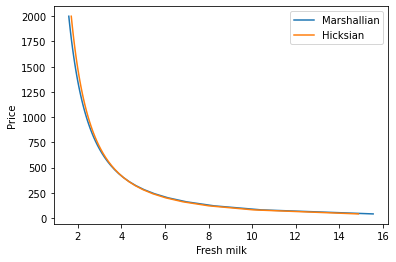

In [27]:
my_i = 'Fresh milk'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"));

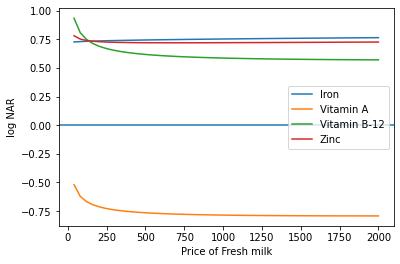

In [28]:
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i);

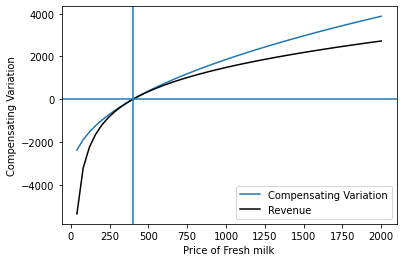

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i]);

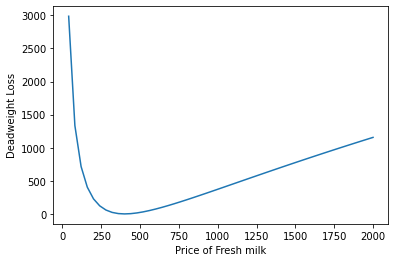

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss");